# Assignment Week 10: Text Mining using Dimensionality Reduction Methods

## Student ID: XXXXXXXX

This dataset comes from the website [Internet Movie Database](https://www.imdb.com/), and represents 1,000 reviews which were labeled (by humans) as positive or negative, see [here](http://ai.stanford.edu/~amaas/data/sentiment/) for more details. In this coursework, we will study how we can use dimensionality reduction methods to improve our understanding of text data and to predict the sentiment of a set of texts. This application of data science is called [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis) and it is widely used across many fields to get automated feedback when text opinions are expressed. While most modern methods of sentiment analysis are using complex deep learning methods, the tools we have seen this week can be readily applied to get a good idea of what our users are expressing.

In [1]:
# Import other packages if you need them!
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn.feature_extraction.text as sktext
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score


# Plotting
import matplotlib.pyplot as plt 
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Data import

The dataset comes with the text and a binary variable which represents the sentiment, either positive or negative. The following code imports the data, splits it into train and test, and applies the [Tf-Idf transform](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) (see the lectures, slide 34).

In [2]:
# Be sure to first leave the data here!
imdb_data = pd.read_excel('IMDB_Sample.xlsx')


# Scikit-Learn works by first defining the der 
TfIDFTransformer = sktext.TfidfVectorizer(strip_accents='unicode', # Eliminate accents and special characters
                      stop_words='english', # Eliminates stop words.
                      min_df = 0.05, # Eliminate words that do not appear in more than 5% of texts
                      max_df = 0.95, # Eliminate words that appear in more than 95% of texts
                      sublinear_tf=True # Use sublinear weights (softplus)
                      )

# Train / test split
x_train, x_test, y_train, y_test = train_test_split(imdb_data['texts'],
                                                    imdb_data['class'],
                                                    test_size=0.3,
                                                    random_state=20210318)

# Calculate the Tf-Idf transform.
TfIDF_train = TfIDFTransformer.fit_transform(x_train)
TfIDF_test = TfIDFTransformer.transform(x_test)

# Turn to dense matrix as PCA does not like sparse ones.
TfIDF_train = TfIDF_train.toarray()
TfIDF_test = TfIDF_test.toarray()

<ipython-input-2-f6f489a0514b>:2: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  imdb_data = pd.read_excel('IMDB_Sample.xlsx')


From here on, you will use the variables `TfIDF_train` and `TfIDF_test` as the input for the different tasks, and the `y_train` and `y_test` labels for each dataset (if required).  The output is a **sparse matrix** with the 236 words that do not appear in more than 95% of texts nor in less than 5% of texts. These matrices only store the relevant information! They are *much* more efficient in-memory.  Sadly, PCA nor torch deal very well with sparse matrices without further processing, so we turn them into dense matrices.

We can check the outputs of the first row with the below code.

In [3]:
print(TfIDF_train[1,:])

[0.         0.         0.         0.         0.         0.16565558
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.24573797 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.17111284 0.
 0.         0.         0.         0.         0.17934085 0.
 0.18989355 0.         0.20293873 0.         0.         0.
 0.         0.         0.15861506 0.         0.28146216 0.15964171
 0.         0.         0.13397591 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.2143442  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.11417021 0.
 0.         0.         0.         0.         0.19858848 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.1750

Each column represents one word and each non-zero value represents the Tf-IDF weight as seen in the lectures. To find out which word is which in the index, you can use the [`TfIDFTransformer.get_feature_names()` method](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

In [4]:
print('There are %i words in the index.' % len(TfIDFTransformer.get_feature_names()))

There are 236 words in the index.


## Task 1: PCA decomposition of the texts. [35 pts]

Now you have the TfIDF matrix, We can start working on the data. As a first step, we want to explore what some commonly occuring concepts in the text reviews. We can do this using PCA. A PCA transform of the TF-IDF matrix will give you a basis of the text data, each representing a *concept* or set of words that are correlated. Correlation in text can be interpreted as a relation to a similar topic.

1. First, calculate a PCA transform of the training data using the **maximum** number of concepts possible. Make a plot of the explained variance that shows the cumulative explained variance per number of concepts. 

**Written answer: Exactly how many concepts do you need to correctly explain at least 75% of the data? (note we need the exact # of concepts)**  [15 pts]

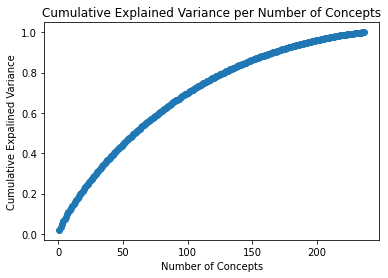

In [37]:
# Your code here.
PCA_max=PCA(n_components=236)
PCA_max.fit_transform(TfIDF_train)
variance_list=[]
# Make the plot
cumulative_variance=0
for i in range (1,237):
    cumulative_variance+=PCA_max.explained_variance_ratio_[i-1]
    variance_list.append(cumulative_variance)

plt.scatter([i for i in range(1,237,1)], variance_list)
plt.xlabel('Number of Concepts')
plt.ylabel('Cumulative Expalined Variance')
plt.title('Cumulative Explained Variance per Number of Concepts')
plt.show()

In [38]:
# To get the exact index where the variance is above 75%
cumulative_variance=0
exact_number=0
for i in range (1,237):
    cumulative_variance+=PCA_max.explained_variance_ratio_[i-1]
    if cumulative_variance>0.75:
        exact_number=i
        break

print("We need ",exact_number," concepts to explain at least 75% of data")

We need  114  concepts to explain at least 75% of data


**Written answer: **
we need 114 concepts to explain at least 75% of data

2. Study the first three concepts. To do this, show the 10 words that are the most important in the each of these three concepts (as revealed by the absolute value of the PCA weight in each concept).

**Written answer: What is the cumulative variance explained by these three concepts? What would you name each of these concepts?** [10 pts]
*Hint: if in a concept you would get the words 'dog', 'cat', 'fish' as the most important ones, you could name the concept 'animals' or 'pets'.*

In [39]:
# Explained variance.
threeconcept_variance=0
for i in range (3):
    threeconcept_variance+=PCA_max.explained_variance_ratio_[i]
print("cumulative variance explained by these three concepts is",threeconcept_variance)

cumulative variance explained by these three concepts is 0.048604638960120294


In [40]:
# Get words per component
concept1=PCA_max.components_[0,:]
concept2=PCA_max.components_[1,:]
concept3=PCA_max.components_[2,:]


wordindex1=np.argpartition(-concept1, 10)
wordindex1=wordindex1[:10]

wordindex2=np.argpartition(-concept2, 10)
wordindex2=wordindex2[:10]

wordindex3=np.argpartition(-concept3, 10)
wordindex3=wordindex3[:10]

In [41]:
# Concept 1
for i in range(10):
    print(TfIDFTransformer.get_feature_names()[wordindex1[i]])

bad
think
movie
like
terrible
movies
don
watch
just
thought


In [42]:
# Concept 2
for i in range(10):
    print(TfIDFTransformer.get_feature_names()[wordindex2[i]])

series
characters
great
love
loved
excellent
story
john
cast
movies


In [43]:
# Concept 3
for i in range(10):
    print(TfIDFTransformer.get_feature_names()[wordindex3[i]])

new
man
funny
old
original
series
comedy
little
thing
star


**Written answer: ** cumulative variance explained by these three concepts is 0.048604638960120294. First concept is "bad", because all those words come from bad reviews. The second concept is "good", because all these words come from good reviews. The third concept is "neutral", because all these words are neither negative nor positive. 

3. Apply the PCA transformation to the test dataset. Using only the first two components, make a scatter plot of the cases. Identify positive and negative cases by colouring points with different sentiments with different colours. 

**Written answer: What can you say about where the positive and negative cases lie in your plot? Could we use these concepts to discriminate positive and negative cases? If yes, why? If no, why not? Discuss your findings.** [10 pts]

Text(0, 0.5, 'Second component')

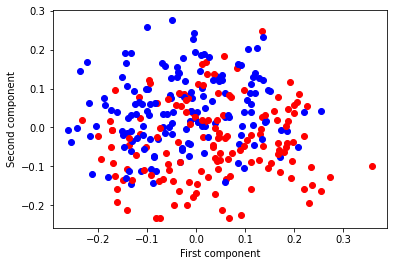

In [61]:
# Apply the test data

test_result=PCA_max.transform(TfIDF_test)
# Plot the two different set of points filtering by label.
counter=0
for i in y_test:
    if i==1:
        plt.scatter(test_result[counter,0],test_result[counter,1],c="blue")
    else:
        plt.scatter(test_result[counter,0],test_result[counter,1],c="red")
    counter+=1

plt.xlabel('First component')
plt.ylabel('Second component')


**Written answer:**

most positive cases lie in the top left portion of the plot, and most negative cases lie in the bottom right portion of the plot. However, these two concepts still cannot be used to discriminate positive and negative cases. Many positive and negative cases lit in the middle of the plot, so these cases have similar values for the first two concepts. This means that using the first two concepts cannot completely distinguish these positive and negative cases in the middle of the plot. 

## Task 2: Autoencoders [35 pts]

We will see now the ability of autoencoders to compress the data. Train an autoencoder that compresses the data to 60 neurons in the encoding layer as shown in lab 10.2, to be trained over the original TfIDF train dataset. Use a total of 5 fully connected layers going from 236 to 100 to 60 to 100 to 236 units. Use a relu non-linearity for each of them. Then try at two more variations of this network. You could vary the number of hidden units, number of layers, or the type of nonlinearity that you are using. Train the models, each time reducing model reconstruction error. For each model you train, plot the reconstruction error (MSE) over the train set and the test set as you train every 100 rounds. 

**Written answer: Which of your models performs the best? After how many epochs does your best model reach convergence? Does your model overfit? If yes, why do you think this is? If no, why?** [10 pts each architecture plus 5 pts arguing which one is better plus the explaining of overfitting]

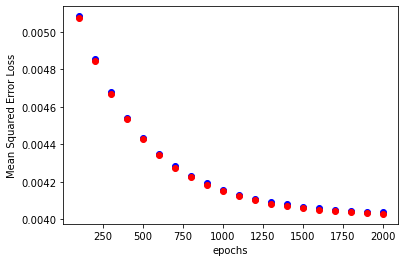

In [86]:
# Model architecture and definition
from IPython.display import clear_output

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(236,100),
            nn.ReLU(),
            nn.Linear(100,60),
            nn.ReLU()
            )
        self.decoder = nn.Sequential(
            nn.Linear(60,100),
            nn.ReLU(),
            nn.Linear(100,236),
            nn.ReLU()
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


#build model
auto_enc= autoencoder()

#define loss function
loss_fn = torch.nn.MSELoss()

#define learning rate
learning_rate = 1e-1

#convert dataset to tensors
X_scaled = torch.from_numpy(TfIDF_train)
X_test=torch.from_numpy(TfIDF_test)
#train model
trainingloss=[]
testloss=[]
numbindex=[]
for t in range (2000):
  y_pred = auto_enc(X_scaled.float())
  loss = loss_fn(y_pred.float(), X_scaled.float())
  if t % 100 == 99:
        clear_output(wait=True)
        numbindex.append(t+1)
        trainingloss.append(loss.item())
        y_pred_test = auto_enc.forward(torch.Tensor(X_test.float()))
        testloss.append(loss_fn(y_pred_test,X_test).item())
        plt.scatter(numbindex,trainingloss,label="training loss",c="blue")
        plt.scatter(numbindex,testloss,label="test loss",c="red")
        plt.xlabel("epochs") 
        plt.ylabel("Mean Squared Error Loss") 
        plt.show() 
        
        
  auto_enc.zero_grad()
  loss.backward()
  with torch.no_grad():
        for param in auto_enc.parameters():
            param -= learning_rate * param.grad 



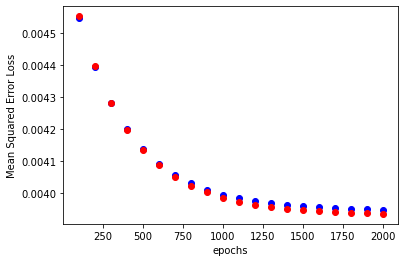

In [87]:
# model 2 more layers
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(236,160),
            nn.ReLU(),
            nn.Linear(160,100),
            nn.ReLU(),
            nn.Linear(100,60),
            nn.ReLU()
            )
        self.decoder = nn.Sequential(
            nn.Linear(60,100),
            nn.ReLU(),
            nn.Linear(100,160),
            nn.ReLU(),
            nn.Linear(160,236),
            nn.ReLU()
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


#build model
auto_enc= autoencoder()

#define loss function
loss_fn = torch.nn.MSELoss()

#define learning rate
learning_rate = 1e-1

#convert dataset to tensors
X_scaled = torch.from_numpy(TfIDF_train)
X_test=torch.from_numpy(TfIDF_test)
#train model
trainingloss=[]
testloss=[]
numbindex=[]
for t in range (2000):
  y_pred = auto_enc(X_scaled.float())
  loss = loss_fn(y_pred.float(), X_scaled.float())
  if t % 100 == 99:
        clear_output(wait=True)
        numbindex.append(t+1)
        trainingloss.append(loss.item())
        y_pred_test = auto_enc.forward(torch.Tensor(X_test.float()))
        testloss.append(loss_fn(y_pred_test,X_test).item())
        plt.scatter(numbindex,trainingloss,label="training loss",c="blue")
        plt.scatter(numbindex,testloss,label="test loss",c="red")
        plt.xlabel("epochs") 
        plt.ylabel("Mean Squared Error Loss") 
        plt.show() 
        
        
  auto_enc.zero_grad()
  loss.backward()
  with torch.no_grad():
        for param in auto_enc.parameters():
            param -= learning_rate * param.grad 


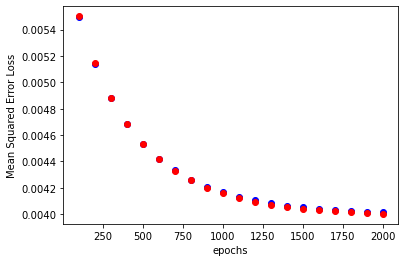

In [89]:
#model 3 more hidden units
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(236,80),
            nn.ReLU(),
            nn.Linear(80,60),
            nn.ReLU()
            )
        self.decoder = nn.Sequential(
            nn.Linear(60,80),
            nn.ReLU(),
            nn.Linear(80,236),
            nn.ReLU()
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


#build model
auto_enc= autoencoder()

#define loss function
loss_fn = torch.nn.MSELoss()

#define learning rate
learning_rate = 1e-1

#convert dataset to tensors
X_scaled = torch.from_numpy(TfIDF_train)
X_test=torch.from_numpy(TfIDF_test)
#train model
trainingloss=[]
testloss=[]
numbindex=[]
for t in range (2000):
  y_pred = auto_enc(X_scaled.float())
  loss = loss_fn(y_pred.float(), X_scaled.float())
  if t % 100 == 99:
        clear_output(wait=True)
        numbindex.append(t+1)
        trainingloss.append(loss.item())
        y_pred_test = auto_enc.forward(torch.Tensor(X_test.float()))
        testloss.append(loss_fn(y_pred_test,X_test).item())
        plt.scatter(numbindex,trainingloss,label="training loss",c="blue")
        plt.scatter(numbindex,testloss,label="test loss",c="red")
        plt.xlabel("epochs") 
        plt.ylabel("Mean Squared Error Loss") 
        plt.show() 
        
        
  auto_enc.zero_grad()
  loss.backward()
  with torch.no_grad():
        for param in auto_enc.parameters():
            param -= learning_rate * param.grad 


**Written answer:**

Model 2 is the best model. When models reach convergence, the training errors of model 2 are the lowest. Therefore, model 2 is a better fit to training and test data. The model reaches convergence after 1600 epochs. The model did not overfit, because our model is not very complex. The model does not have a lot of hidden layers and hidden units. Therefore, the training and test errors of our model are both low. 

## Task 3: Benchmarking predictive capabilities of the compressed data. [30 pts]

For the final task, you will benchmark the different compression algorithms over the original data. For this:

1. Train a regularized logistic regression over the original TfIDF train set (with no compression) to predict the positive / negative class label for each movie. Calculate the AUROC over the test set.
2. Train a regularized logistic regression over the PCA-reduced dataset (with 60 components), and calculate the AUROC over the PCA-transformed test set.
3. Train a regularized logistic regression over the encoded dataset (with 60 variables), and calculate AUROC over the encoded test set.

**Written answer 1: Compare the performance of the three models: how do they compare?**

**Written answer 2: Which of the two compression methods (methods 2 and 3) is better at compressing the data without altering its predictive capacity? Why do you think this happens?**

In [117]:
# Full dataset regression and AUC plot / calculation
from sklearn.metrics import make_scorer 
myscorer = make_scorer(
         roc_auc_score
)
model=LogisticRegressionCV(scoring=myscorer,max_iter = 1000000, multi_class='auto').fit(TfIDF_train,y_train.values)
print("model 1:",model.score(TfIDF_test,y_test.values))

model 1: 0.7545810354029532


In [118]:
# PCA dataset regression and AUC plot / calculation
PCA_train=PCA(n_components=60)
X_PCA=pd.DataFrame(PCA_train.fit_transform(TfIDF_train))
PCA_test=PCA(n_components=60)
test_PCA=pd.DataFrame(PCA_test.fit_transform(TfIDF_test))

PCAmodel=LogisticRegressionCV(scoring=myscorer,max_iter = 1000000, multi_class='auto').fit(X_PCA,y_train.values)
print("model 2:",PCAmodel.score(test_PCA,y_test.values))

model 2: 0.6637164205657357


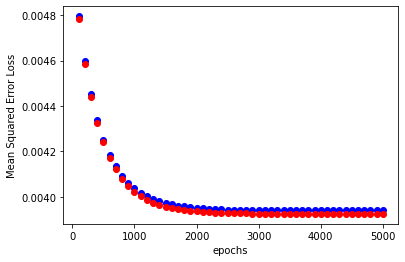

In [125]:
# Autoencoder dataset regression and AUC plot / calculation
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(236,100),
            nn.ReLU(),
            nn.Linear(100,60),
            nn.ReLU()
            )
        self.decoder = nn.Sequential(
            nn.Linear(60,100),
            nn.ReLU(),
            nn.Linear(100,236),
            nn.ReLU()
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


#build model
auto_enc= autoencoder()

#define loss function
loss_fn = torch.nn.MSELoss()

#define learning rate
learning_rate = 1e-1

#convert dataset to tensors
X_scaled = torch.from_numpy(TfIDF_train)
X_test=torch.from_numpy(TfIDF_test)
#train model
trainingloss=[]
testloss=[]
numbindex=[]
for t in range (5000):
  y_pred = auto_enc(X_scaled.float())
  loss = loss_fn(y_pred.float(), X_scaled.float())
  if t % 100 == 99:
        clear_output(wait=True)
        numbindex.append(t+1)
        trainingloss.append(loss.item())
        y_pred_test = auto_enc.forward(torch.Tensor(X_test.float()))
        testloss.append(loss_fn(y_pred_test,X_test).item())
        plt.scatter(numbindex,trainingloss,label="training loss",c="blue")
        plt.scatter(numbindex,testloss,label="test loss",c="red")
        plt.xlabel("epochs") 
        plt.ylabel("Mean Squared Error Loss") 
        plt.show() 
        
        
  auto_enc.zero_grad()
  loss.backward()
  with torch.no_grad():
        for param in auto_enc.parameters():
            param -= learning_rate * param.grad 



In [126]:
encoder_train=auto_enc.encoder(X_scaled.float()).detach().numpy()
encoder_test=auto_enc.encoder(X_test.float()).detach().numpy()
encodermodel=LogisticRegressionCV(scoring=myscorer,max_iter = 1000000, multi_class='auto').fit(encoder_train,y_train.values)
print("model 3:",encodermodel.score(encoder_test,y_test.values))

model 3: 0.5576854652197117


**Written answer:**

Answer1: The model without compression performs the best. The second best model is the model that was trained on PCA-reduced data set. The worst model is the model that was trained on encoded dataset.

Answer2:  methods 2 is better at compressing the data without altering its predictive capacity.PCA is a method for linear dimensionality reduction, and autoencoder is a method for nonlinear dimensionality reduction. We are doing logistic regression to predict positive/negative for each movie. Then our model will not be very complex. PCA will shift and stretch the data, but the data will not make dramatic changes. The logistic regression model can still fit the data. Autoencoder will make more dramatic changes on data, because it is a nonlinear dimensionality reduction method. Then it is harder for our logistic regression model to fit the data after autoencoding. As a result, autoencoding will impair its predictive capacity.